In [1]:
import psutil
import os
import surprise
import ast

import pandas as pd
import kagglehub as kh
import plotly.express as px
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from scipy.sparse import csr_matrix
from surprise import SVD

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) # Set GPU memory growth, if exists
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2025-04-26 21:45:08.585521: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-04-26 21:45:08.585548: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-04-26 21:45:08.585553: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-04-26 21:45:08.585622: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-26 21:45:08.585660: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

In [5]:
def print_memory():
    process = psutil.Process(os.getpid())
    print(round(process.memory_info().rss/(10**9),3), 'Gbytes')  # in bytes 

In [6]:
path = kh.dataset_download("mohamedbakhet/amazon-books-reviews")

In [7]:
df_ratings = pd.read_csv(os.path.join(path, 'Books_rating.csv'))
df_data = pd.read_csv(os.path.join(path, 'books_data.csv'))

In [8]:
df_ratings.head(5)

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [9]:
df_data.head(5)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [10]:
len(df_ratings[df_ratings['review/score']==0])

0

In [11]:
df_ratings.isna().sum() 

Id                          0
Title                     208
Price                 2518829
User_id                561787
profileName            561905
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
dtype: int64

In [12]:
df_data.isna().sum()

Title                 1
description       68442
authors           31413
image             52075
previewLink       23836
publisher         75886
publishedDate     25305
infoLink          23836
categories        41199
ratingsCount     162652
dtype: int64

In [13]:
df_sentiment = df_ratings.copy()
df_sentiment = df_sentiment.drop(['Title', 'Price', 'User_id', 'profileName', 'review/helpfulness', 'review/time', 'review/summary'], axis=1)
df_sentiment.head(5)

,Id,review/score,review/text
0,1882931173,4.0,This is only for Julie Strain fans. It's a col...
1,0826414346,5.0,I don't care much for Dr. Seuss but after read...
2,0826414346,5.0,"If people become the books they read and if ""t..."
3,0826414346,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,4.0,Philip Nel - Dr. Seuss: American IconThis is b...


In [14]:
len(df_sentiment)

3000000

In [15]:
df_sentiment['review/text'] = df_sentiment['review/text'].str.lower().str.strip().str.replace(r'[\n\t]', ' ')
df_sentiment.head(1)

,Id,review/score,review/text
0,1882931173,4.0,this is only for julie strain fans. it's a col...


In [16]:
duplicates = df_sentiment[df_sentiment.duplicated()]
print(duplicates)

                 Id  review/score  \
256      0312322291           4.0   
267      9687968478           5.0   
423      0671551345           5.0   
429      0671551345           5.0   
536      1597400602           2.0   
...             ...           ...   
2999629  B000P91JYW           5.0   
2999633  B000P91JYW           5.0   
2999690  B000P91JYW           1.0   
2999709  0072228997           5.0   
2999828  0762417137           5.0   

                                               review/text  
256      king james by ryan jones is a biography of leb...  
267      de lucha y triunfo..este libro te dejar&aacute...  
423      this book was outstanding! i couldn't put it d...  
429      i was sceptical about this book at first, i ha...  
536      unless you are under obligation to read this f...  
...                                                    ...  
2999629  it's hard to imagine a better gothic romance t...  
2999633  it's hard to imagine a better gothic romance t...  
299969

In [17]:
print(len(df_sentiment))
df_sentiment = df_sentiment.drop_duplicates(subset='review/text')
print(len(df_sentiment))

3000000
2062533


In [18]:
len(df_sentiment[df_sentiment['review/text']==''])

0

In [19]:
grouped_df = df_sentiment.groupby('review/score').size().reset_index(name='frequency')

fig = px.bar(grouped_df, x='review/score', y='frequency')
fig.show('plotly_mimetype')

In [20]:
n_samples_per_class = 40_000

df = df_sentiment.groupby('review/score', group_keys=False).apply(
    lambda x: x.sample(n=n_samples_per_class, random_state=42)
).reset_index(drop=True)

In [21]:
df.head()

,Id,review/score,review/text
0,0879307102,1.0,i was extremely disappointed in this book. the...
1,055214245X,1.0,"the gift is the perfect example of telling, no..."
2,1593352166,1.0,"with naked empire, goodkind finally cemented h..."
3,B0000CO4JZ,1.0,bought this book because it was recommended as...
4,0965927393,1.0,don't waste your money on this book. better ye...


In [22]:
grouped_df_2 = df.groupby('review/score').size().reset_index(name='frequency')

fig = px.bar(grouped_df_2, x='review/score', y='frequency')
fig.show('plotly_mimetype')
#fig.write_image('sampled.png')

In [23]:
group_kfold = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Iterate the GroupShuffleSplit for 1 split, grouping the dataframe and its ratings based on book ID, as described earlier
train_set, test_set = None, None
for train_index, test_index in group_kfold.split(df, df['review/score'], groups=df['Id']):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

print(len(train_set))
print(len(test_set))

160548
39452


In [24]:
X_train = train_set['review/text'].tolist()
y_train = train_set['review/score'].tolist()
X_test = test_set['review/text'].tolist()
y_test = test_set['review/score'].tolist()

# Make a validation set out of the full 80% train set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [25]:
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-mini")

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [26]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=200)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=200)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=200)

In [27]:
model = TFAutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-mini", num_labels=6, from_pt=True)

opt = tf.keras.optimizers.Adam(learning_rate=1e-5, weight_decay=0.01)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [29]:
training_now = True

In [30]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
             tf.keras.callbacks.ModelCheckpoint(filepath='models/best_model', monitor='val_loss', save_best_only=True, save_weights_only=True)]

if training_now:
    history = model.fit(train_dataset.shuffle(1000).batch(64), epochs=30, batch_size=128, 
                        validation_data=val_dataset.shuffle(1000).batch(64), callbacks=callbacks)
else:
    print('Training completed earlier. Skipping this step.')

Epoch 1/30


2025-04-26 21:47:04.847287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-26 21:47:05.025751: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-04-26 21:47:05.104726: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


2007/2007 [==============================] - ETA: 0s - loss: 1.3636 - accuracy: 0.4144

2025-04-26 21:51:08.492886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-26 21:51:08.537994: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-04-26 21:51:08.559206: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


2007/2007 [==============================] - 272s 133ms/step - loss: 1.3636 - accuracy: 0.4144 - val_loss: 1.1969 - val_accuracy: 0.4833
Epoch 2/30
2007/2007 [==============================] - 296s 147ms/step - loss: 1.1727 - accuracy: 0.4937 - val_loss: 1.1312 - val_accuracy: 0.5104
Epoch 3/30
2007/2007 [==============================] - 288s 143ms/step - loss: 1.1219 - accuracy: 0.5122 - val_loss: 1.1146 - val_accuracy: 0.5146
Epoch 4/30
2007/2007 [==============================] - 274s 136ms/step - loss: 1.0891 - accuracy: 0.5259 - val_loss: 1.0901 - val_accuracy: 0.5273
Epoch 5/30
2007/2007 [==============================] - 276s 137ms/step - loss: 1.0600 - accuracy: 0.5394 - val_loss: 1.0786 - val_accuracy: 0.5315
Epoch 6/30
2007/2007 [==============================] - 274s 137ms/step - loss: 1.0363 - accuracy: 0.5491 - val_loss: 1.0778 - val_accuracy: 0.5346
Epoch 7/30
2007/2007 [==============================] - 274s 136ms/step - loss: 1.0146 - accuracy: 0.5583 - val_loss: 1.081

In [31]:
if training_now:
    dfr = pd.DataFrame(history.history)

    dfr['epoch'] = dfr.index + 1

    fig = px.line(dfr, x='epoch', y=['accuracy', 'val_accuracy'], title='Accuracy vs Epoch')
    fig.show('plotly_mimetype')
    fig.write_image('imgs/accuracy.png')
else:
    print('Not training now. See previous accuracy plot.')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [32]:
if training_now:
    fig = px.line(dfr, x='epoch', y=['loss','val_loss'], title='Loss vs Epoch')
    fig.show('plotly_mimetype')
    fig.write_image('imgs/loss.png')
else:
    print('Not training now. See previous loss plot.')

In [33]:
best_model = TFAutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-mini", num_labels=6, from_pt=True)
best_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

best_model.load_weights('models/best_model')

evals = best_model.evaluate(test_dataset.batch(64))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-04-26 22:37:50.660943: I tensorflow/core/grappler/optimizers/

617/617 [==============================] - 28s 44ms/step - loss: 1.9185 - accuracy: 0.5386


2025-04-26 22:38:18.527736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-26 22:38:18.575272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-04-26 22:38:18.595039: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


2466/2466 [==============================] - 48s 19ms/step


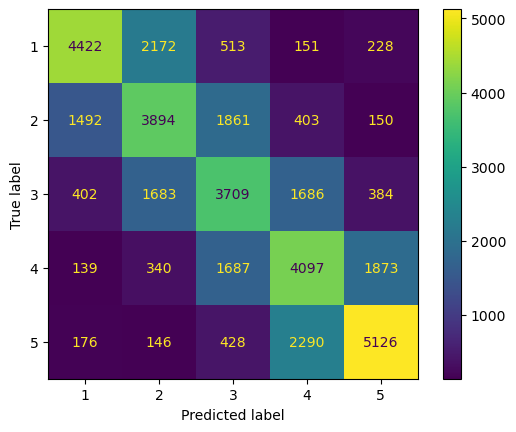

In [34]:
y_pred = best_model.predict(test_dataset.batch(16)) 
y_pred = tf.nn.softmax(y_pred.logits) 
y_pred = tf.argmax(y_pred, axis=1) 

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

confusion_matrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[1, 2, 3, 4, 5])

confusion_matrix_display.plot()
plt.savefig('imgs/confusion_matrix.png')
plt.show()

In [35]:
df_cf = df_ratings.copy(deep=True)
df_cf.head(5)

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [36]:
df_cf.columns

Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')

In [37]:
df_cf = df_cf.drop(['Title', 'Price', 'profileName', 'review/helpfulness', 'review/time', 'review/summary', 'review/text'],
                   axis=1)
df_cf.head()

,Id,User_id,review/score
0,1882931173,AVCGYZL8FQQTD,4.0
1,0826414346,A30TK6U7DNS82R,5.0
2,0826414346,A3UH4UZ4RSVO82,5.0
3,0826414346,A2MVUWT453QH61,4.0
4,0826414346,A22X4XUPKF66MR,4.0


In [38]:
df_cf.isna().sum()

Id                   0
User_id         561787
review/score         0
dtype: int64

In [39]:
df_cf = df_cf.dropna(how='any', axis=0)

In [40]:
dupes = df_cf[df_cf.duplicated(subset=['User_id', 'Id'], keep=False)]
print(dupes.sort_values(['User_id', 'Id']))

                 Id                User_id  review/score
410142   B000NDSX6C  A02660181QI9HHAVFK06O           5.0
412741   B000NDSX6C  A02660181QI9HHAVFK06O           5.0
410273   B000NDSX6C   A03816223LL3Q1P48HRU           5.0
413229   B000NDSX6C   A03816223LL3Q1P48HRU           5.0
1255962  B000GQG5MA  A07532193EC6QULM9ZSPJ           5.0
...             ...                    ...           ...
1738754  0613916301          AZYJI5WR8KWEE           5.0
688408   0613103572          AZYYHHWSLTDVS           4.0
688409   0613103572          AZYYHHWSLTDVS           4.0
1559811  8372793476          AZZIAV2JI3FH4           5.0
1559945  8372793476          AZZIAV2JI3FH4           5.0

[71758 rows x 3 columns]


In [41]:
print(len(df_cf))
df_cf = df_cf.drop_duplicates(subset=['User_id', 'Id'], keep='last')
print(len(df_cf))

2438213
2397614


In [42]:
print(len(df_cf.User_id.unique()))
print(len(df_cf.Id.unique()))

1008972
216023


In [43]:
user_enc = LabelEncoder()
item_enc = LabelEncoder()

df_knn = df_cf.copy(deep=True)
df_knn['user_idx'] = user_enc.fit_transform(df_knn['User_id'])
df_knn['item_idx'] = item_enc.fit_transform(df_knn['Id'])

matx_sparse = csr_matrix((df_knn['review/score'],
                        (df_knn['user_idx'], df_knn['item_idx'])))

In [44]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
knn.fit(matx_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

In [45]:
def print_recommendations(vals, user_id):
    print(f'Top {len(vals)} Recommendations for {user_id}')
    for _, data in enumerate(vals):
        print(f'ID: {data[0]}, Pred Score: {data[1]}')

In [46]:
def predict_rating_knn(user_id, n_recs=5):
    user_idx = user_enc.transform([user_id])[0]

    distances, indices = knn.kneighbors(matx_sparse[user_idx], n_neighbors=30)

    similar_users = indices.flatten()
    similarities = 1 - distances.flatten()

    scores = {}
    sim_sums = {}

    user_rated_items = set(matx_sparse[user_idx].nonzero()[1])

    for neighbor_idx, sim_user_idx in enumerate(similar_users):
        if sim_user_idx == user_idx:
            continue

        similarity = similarities[neighbor_idx]
        if similarity <= 0:
            continue

        sim_user_row = matx_sparse.getrow(sim_user_idx)
        for item_idx, rating in zip(sim_user_row.indices, sim_user_row.data):
            if item_idx in user_rated_items:
                continue

            scores[item_idx] = scores.get(item_idx, 0) + similarity*rating
            sim_sums[item_idx] = sim_sums.get(item_idx, 0) + similarity

    for item in scores:
        scores[item] /= sim_sums[item]

    if n_recs is not None:
        ranked_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:n_recs]
    else:
        ranked_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:]

    recs = [(item_enc.inverse_transform([idx])[0], score) for idx, score in ranked_items]
    return recs

In [47]:
ex_user_id = 'A30TK6U7DNS82R'
pred = predict_rating_knn(ex_user_id)
print_recommendations(pred, ex_user_id)

Top 5 Recommendations for A30TK6U7DNS82R
ID: 0002312840, Pred Score: 5.0
ID: 0002313197, Pred Score: 5.0
ID: 0007128673, Pred Score: 5.0
ID: 0333989015, Pred Score: 5.0
ID: 033398904X, Pred Score: 5.0


In [48]:
reader = surprise.Reader(rating_scale=(1, 5))
data = surprise.Dataset.load_from_df(df_cf[['User_id', 'Id', 'review/score']], reader)

train, test = surprise.model_selection.train_test_split(data, test_size=0.2, random_state=42)

In [49]:
algo_svd = SVD(n_factors=50, biased=True, verbose=True)
algo_svd.fit(train)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [50]:
def predict_rating_svd(user_id, df_all, algo, n_recs=5):
    user_books = set(df_all[df_all['User_id']==user_id]['Id'])
    all_books = df_all['Id'].unique()
    books_to_pred = [_ for _ in all_books if _ not in user_books]

    preds = [algo.predict(user_id, _) for _ in books_to_pred]
    preds.sort(key=lambda x: x.est, reverse=True)

    if n_recs is not None:
        return [(_.iid, round(_.est, 2)) for _ in preds[:n_recs]]
    else:
        return [(_.iid, round(_.est, 2)) for _ in preds[:]]

In [51]:
pred = predict_rating_svd(ex_user_id, df_cf, algo_svd)
print_recommendations(pred, ex_user_id)

Top 5 Recommendations for A30TK6U7DNS82R
ID: 1890626570, Pred Score: 5
ID: B000PV74Q2, Pred Score: 5
ID: 1580622666, Pred Score: 5
ID: 0385501528, Pred Score: 5
ID: 0861714911, Pred Score: 5


In [52]:
def hybrid_collaborative_filtering(user_id, df_all, algo, n_recs=None):
    pred_svd = dict(predict_rating_svd(user_id, df_all, algo, n_recs))
    pred_knn = dict(predict_rating_knn(user_id, n_recs))

    keys = list(pred_svd.keys())
    keys.extend(list(pred_knn.keys()))
    keys = tuple(keys)

    pred = {}
    for _ in set(keys):
        pred[_] = (0.5*pred_svd.get(_, 0)) + (0.5*pred_knn.get(_, 0))
    
    recs = sorted(pred.items(), key=lambda x: x[1], reverse=True)
    if n_recs is not None:
        recs = recs[:n_recs]
    return recs

In [53]:
print_recommendations(
    hybrid_collaborative_filtering(ex_user_id, df_cf, algo_svd)[:10],
    ex_user_id
)

Top 10 Recommendations for A30TK6U7DNS82R
ID: B000N8T1L8, Pred Score: 4.8
ID: B000JWND0S, Pred Score: 4.79
ID: B000PC8OLK, Pred Score: 4.785
ID: 0007128673, Pred Score: 4.779999999999999
ID: B000GRC672, Pred Score: 4.77
ID: B0007FYVIA, Pred Score: 4.755
ID: B000J2V5EE, Pred Score: 4.75
ID: 0333989015, Pred Score: 4.75
ID: B0006AV5L2, Pred Score: 4.745
ID: B000P961SQ, Pred Score: 4.745


In [54]:
df_ratings.head(5)

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [55]:
df_data.head(5)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [56]:
print(df_ratings.columns)
print(df_data.columns)

Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')
Index(['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'publishedDate', 'infoLink', 'categories', 'ratingsCount'],
      dtype='object')


In [57]:
df_cont = pd.merge(
    df_ratings.drop(['Price', 'User_id', 'profileName', 'review/helpfulness',
                     'review/score', 'review/time', 'review/summary', 'review/text'], axis=1),
    df_data.drop(['image', 'previewLink', 'publishedDate', 'infoLink', 
                  'publisher', 'ratingsCount'], axis=1),
    on='Title', how='inner'
)

In [58]:
df_cont.head()

,Id,Title,description,authors,categories
0,1882931173,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],['Comics & Graphic Novels']
1,0826414346,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],['Biography & Autobiography']
2,0826414346,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],['Biography & Autobiography']
3,0826414346,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],['Biography & Autobiography']
4,0826414346,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],['Biography & Autobiography']


In [59]:
df_cont.isna().sum()

Id                  0
Title             208
description    640225
authors        390634
categories     551498
dtype: int64

In [60]:
print(len(df_cont))
df_cont = df_cont.dropna(how='any', axis=0)
print(len(df_cont))

3000000
2227748


In [61]:
print(len(df_cont))
df_cont = df_cont.drop_duplicates(keep='first')
print(len(df_cont))

2227748
142814


In [62]:
df_cont.head()

,Id,Title,description,authors,categories
1,0826414346,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],['Biography & Autobiography']
10,0829814000,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],['Religion']
14,0595344550,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],['Fiction']
47,0802841899,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],['Religion']
55,0895554224,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,['Mary Fabyan Windeatt'],['Biography & Autobiography']


In [63]:
df_cont.dtypes

Id             object
Title          object
description    object
authors        object
categories     object
dtype: object

In [64]:
def safe_list_parse(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

In [65]:
df_cont['authors'] = df_cont['authors'].fillna('[]').apply(safe_list_parse)
df_cont['categories'] = df_cont['categories'].fillna('[]').apply(safe_list_parse)

In [66]:
df_cont.head(5)

,Id,Title,description,authors,categories
1,0826414346,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,[Philip Nel],[Biography & Autobiography]
10,0829814000,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,[David R. Ray],[Religion]
14,0595344550,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,[Veronica Haddon],[Fiction]
47,0802841899,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,[Everett Ferguson],[Religion]
55,0895554224,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,[Mary Fabyan Windeatt],[Biography & Autobiography]


In [67]:
df_cont['authors_str'] = df_cont['authors'].apply(lambda x: ' '.join(x))
df_cont['categories_str'] = df_cont['categories'].apply(lambda x: ' '.join(x))

In [68]:
df_cont.head(5)

,Id,Title,description,authors,categories,authors_str,categories_str
1,0826414346,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,[Philip Nel],[Biography & Autobiography],Philip Nel,Biography & Autobiography
10,0829814000,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,[David R. Ray],[Religion],David R. Ray,Religion
14,0595344550,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,[Veronica Haddon],[Fiction],Veronica Haddon,Fiction
47,0802841899,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,[Everett Ferguson],[Religion],Everett Ferguson,Religion
55,0895554224,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,[Mary Fabyan Windeatt],[Biography & Autobiography],Mary Fabyan Windeatt,Biography & Autobiography


In [69]:
df_cont['title_str'] = df_cont['Title'].str.lower().str.strip().str.replace(r'[\n\t]', ' ')
df_cont['authors_str'] = df_cont['authors_str'].str.lower().str.strip().str.replace(r'[\n\t]', ' ')
df_cont['description_str'] = df_cont['description'].str.lower().str.strip().str.replace(r'[\n\t]', ' ')
df_cont['categories_str'] = df_cont['categories_str'].str.lower().str.strip().str.replace(r'[\n\t]', ' ')

In [70]:
df_cont.head()

,Id,Title,description,authors,categories,authors_str,categories_str,title_str,description_str
1,0826414346,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,[Philip Nel],[Biography & Autobiography],philip nel,biography & autobiography,dr. seuss: american icon,philip nel takes a fascinating look into the k...
10,0829814000,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,[David R. Ray],[Religion],david r. ray,religion,wonderful worship in smaller churches,this resource includes twelve principles in un...
14,0595344550,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,[Veronica Haddon],[Fiction],veronica haddon,fiction,whispers of the wicked saints,julia thomas finds her life spinning out of co...
47,0802841899,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,[Everett Ferguson],[Religion],everett ferguson,religion,the church of christ: a biblical ecclesiology ...,in the church of christ: a biblical ecclesiolo...
55,0895554224,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,[Mary Fabyan Windeatt],[Biography & Autobiography],mary fabyan windeatt,biography & autobiography,saint hyacinth of poland,the story for children 10 and up of st. hyacin...


In [71]:
print(len(df_cont))
df_cont = df_cont.drop_duplicates(subset=['title_str', 'description_str',
                                  'authors_str', 'categories_str'],
                                   keep='first')
print(len(df_cont))

142814
134798


In [72]:
df_cont['combined_text'] = (
    df_cont['title_str'] + ' ' +
    df_cont['description_str'] + ' ' +
    df_cont['authors_str'] + ' ' +
    df_cont['categories_str']
)

In [73]:
tfidf = TfidfVectorizer(stop_words='english', max_features=10_000)
tfidf_matrix = tfidf.fit_transform(df_cont['combined_text'])

In [74]:
book_id_map = {book_id: idx for idx, book_id in enumerate(df_cont['Id'])}

In [75]:
def get_user_profile(user_id, df_ratings, tfidf_matrix):
    global book_id_map

    user_ratings = df_ratings[df_ratings['User_id'] == user_id]
    liked_books = user_ratings[user_ratings['review/score'] >= 4]

    if liked_books.empty:
        return None

    indices = liked_books['Id'].map(book_id_map).dropna().astype(int)
    liked_tfidf = tfidf_matrix[indices]

    ratings = liked_books.loc[indices.index, 'review/score'].values
    user_profile = liked_tfidf.multiply(ratings[:, None]).mean(axis=0)
    return user_profile

In [76]:
def content_filtering(user_id, n_recs=5):
    profile = get_user_profile(user_id, df_ratings, tfidf_matrix)
    if profile is None:
        return []

    similarities = cosine_similarity(np.asarray(profile), tfidf_matrix).flatten()

    if n_recs is not None:
        top_indices = similarities.argsort()[-n_recs:][::-1]
    else:
        top_indices = similarities.argsort()[:][::-1]
    
    rec_books = df_cont.iloc[top_indices][['Id', 'Title']]
    rec_scores = similarities[top_indices]

    return list(zip(rec_books['Id'], rec_books['Title'], rec_scores))

In [77]:
content_filtering(ex_user_id)

[('B000JN8D5C', 'Agatha Christie: an Autobiography', 0.31273011871467316),
 ('002911702X',
  'Agatha Christie: The Woman and Her Mysteries',
  0.3015285786904656),
 ('B000NPXG1C',
  'An Overdose of Death: a Hercule Poirot Mystery (Original Title: The Patriotic Murders)',
  0.3001585793771557),
 ('B000N236JC', 'CROOKED HOUSE', 0.2980110760032935),
 ('1578562244',
  'Coming Clean: The True Story of a Cocaine Drug Lord and His Unexpected Encounter with God',
  0.2958944090466337)]

In [78]:
id_to_title = dict(zip(df_ratings['Id'], df_ratings['Title']))

def fill_titles_in_collaborative(values):
    new_values = []

    for _ in values:
        book_id = _[0]
        title = id_to_title.get(book_id, 'Unknown Title')
        new_values.append((book_id, title, _[1]))  # (id, title, score)
    return new_values

In [79]:
def hybrid_filtering(user_id, df_all, algo, n_recs=5, alpha=0.7):
    collaborative = hybrid_collaborative_filtering(user_id, df_all, algo, n_recs=None)
    content = content_filtering(user_id, n_recs=None)

    collaborative = fill_titles_in_collaborative(collaborative)

    collab_dict = {id_: (title, score) for id_, title, score in collaborative}
    content_dict = {id_: (title, score) for id_, title, score in content}

    all_ids = set(collab_dict.keys()).union(content_dict.keys())
    blended = []
    
    for book_id in all_ids:
        title = None
        collab_score = None
        content_score = None

        if book_id in collab_dict:
            title, collab_score = collab_dict[book_id]
        if book_id in content_dict:
            title = title or content_dict[book_id][0]
            content_score = content_dict[book_id][1]

        # Blending logic
        if collab_score is not None and content_score is not None:
            score = alpha*(collab_score/5) + (1-alpha)*content_score
        elif collab_score is not None:
            score = alpha*(collab_score/5)
        else:  # Only content_score
            score = (1-alpha)*content_score

        blended.append((book_id, title, score))

    # Optionally sort by score descending
    blended.sort(key=lambda x: x[2], reverse=True)
    if n_recs is not None:
        return blended[:n_recs]
    else:
        return blended[:]

In [80]:
hybrid_filtering(ex_user_id, df_cf, algo_svd)

[('B000GLN7GM', 'Death Comes As The End', 0.7408811153814204),
 ('B000JHHYC6', 'By the Pricking of My Thumbs', 0.7283960988401783),
 ('B000N8T1L8', 'They Came to Baghdad.', 0.7223848243527505),
 ('B00005WNGE', 'A pocket full of rye', 0.7160803177641427),
 ('B000KAXCZU', 'A Pocket Full of Rye', 0.715927149796904)]